EXPLORACIÓN DE DATOS

In [9]:
import pandas as pd
import seaborn as sns

In [4]:
ingredients = pd.read_csv('data_ingredientes.csv')
ingredients.head()

,FY,Month,ingredients,inventory adjustment MP
0,2023-2024,12,mp0002,1.12
1,2023-2024,12,mp0003,11.40
2,2023-2024,12,mp0004,-2.89
3,2023-2024,12,mp0005,-15.89
4,2023-2024,12,mp0006,9.84


In [5]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FY                       358 non-null    object 
 1   Month                    358 non-null    int64  
 2   ingredients              358 non-null    object 
 3   inventory adjustment MP  358 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


ÁNALISIS DESCRIPTIVO

In [7]:
ingredients['inventory adjustment MP'].describe()

count    358.000000
mean      -1.174888
std       15.538161
min     -141.180000
25%       -0.467500
50%       -0.010000
75%        0.350000
max      129.800000
Name: inventory adjustment MP, dtype: float64

- La distribución parece estar sesgada por valores extremos, ya que la media es más baja que la mediana.
- Posibles outliers en ambos extremos (-141.18 y 129.80), lo que podría requerir una inspección más detallada.
- La mayoría de los datos se concentran entre -0.467 y 0.35, lo que indica que la variable en su mayoría se mantiene en valores pequeños.
- Puede tratarse de una variable con una ligera asimetría negativa, ya que la media es menor a la mediana.

<Axes: xlabel='inventory adjustment MP', ylabel='Count'>

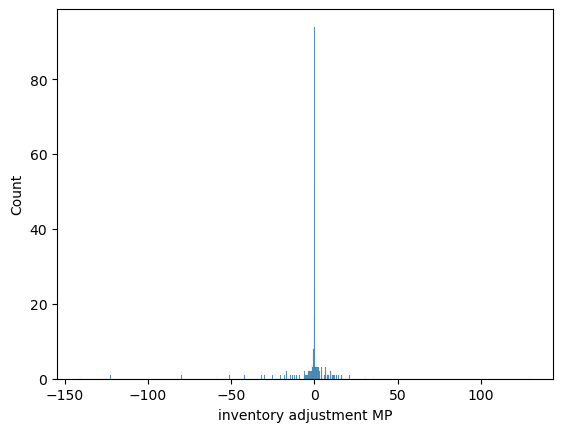

In [11]:
sns.histplot(ingredients['inventory adjustment MP'])

De acuerdo al proceso mapeado es normal que los ingredientes tengan varias discrepancias en sus valores, debido a que se pueden dar dos tipos de ajustes de materia prima:

La primera se da por ajustes de sobredosificación, estas se dan por el proceso normal de dosificación de los tornillos y básculas utilizadas. Los valores máximo deben alcanzar el 5% del peso total que debe ser dosificado por formulación.

La seguna se da por diferencias de inventarios, estas frecuentemente suelen ser valor mayores al porcentaje definido en el punto anterior.

Por lo cual se agregará una columna extra para analizar estos valores por separados. Como no poseemos los detalles de las fórmulas por ingredientes se asumira el 2% de un batch o parada de 4 ton. Por lo que el 5% de 4 Ton es: 200 kg o 0.2 ton.

In [19]:
ingredients['tipo de ajuste'] = ingredients['inventory adjustment MP'].apply(lambda x: 'Inventory Diff' if abs(x) > 0.2 else 'Inventory Dosage')
ingredients['tipo de ajuste'].value_counts()

tipo de ajuste
Inventory Diff      222
Inventory Dosage    136
Name: count, dtype: int64

In [20]:
filter = ingredients['tipo de ajuste'] == 'Inventory Dosage'
ingredients[filter]['inventory adjustment MP'].describe()

count    136.000000
mean      -0.010735
std        0.085632
min       -0.200000
25%       -0.052500
50%        0.000000
75%        0.040000
max        0.200000
Name: inventory adjustment MP, dtype: float64

<Axes: xlabel='inventory adjustment MP', ylabel='Count'>

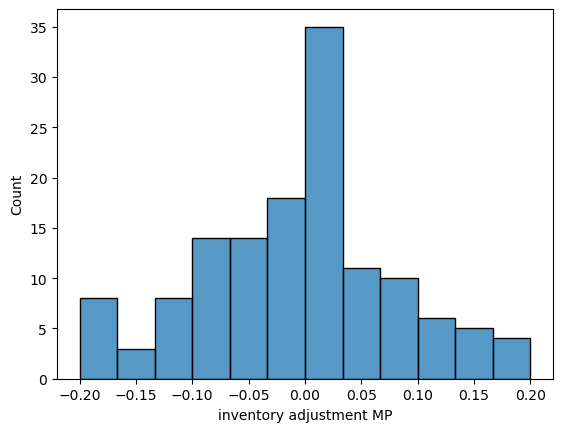

In [21]:
sns.histplot(ingredients[filter]['inventory adjustment MP'])

-  Distribución equilibrada: La mediana en cero sugiere que los datos están bien distribuidos sin una fuerte tendencia a valores negativos o positivos.
-  Poca dispersión: Los valores poseen una desviación estandar de 0.0856, por lo que se puede asumir un proceso estable.
-  Posibles valores extremos en -0.20 y 0.20: Aunque no son outliers evidentes, se debe verificar la distribución visualmente.
-  Ligeramente sesgada hacia valores negativos: La media es menor a la mediana, aunque la diferencia no es muy significativa.

Dentro de este análisis enfocado a diferencias solo de diferencias de dosificación se puede observar un proceso estable. Con pocas variaciones o outliers, pero con una tendencia a existir mayor cantidad de valores hacia la izquierda, sugiriendo que existe mayor cantidad de sobredosificaciones en el proceso.

In [22]:
filter = ingredients['tipo de ajuste'] == 'Inventory Diff'
ingredients[filter]['inventory adjustment MP'].describe()

count    222.000000
mean      -1.888063
std       19.714463
min     -141.180000
25%       -2.432500
50%       -0.230000
75%        2.662500
max      129.800000
Name: inventory adjustment MP, dtype: float64

<Axes: xlabel='inventory adjustment MP', ylabel='Count'>

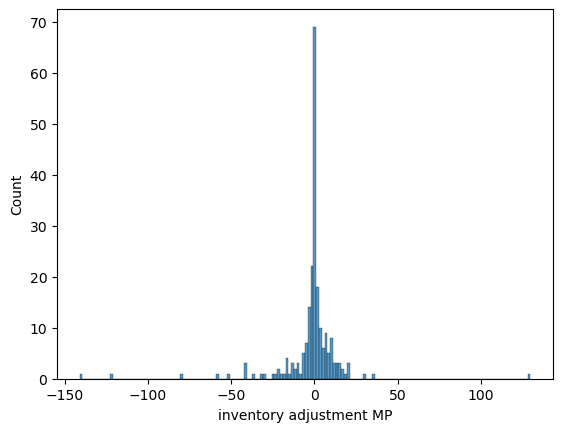

In [23]:
sns.histplot(ingredients[filter]['inventory adjustment MP'])

- Predominio de ajustes negativos: La media y mediana indican que los ajustes suelen ser pérdidas en el inventario de materia prima.
- Alta variabilidad: La desviación estándar y el amplio rango sugieren que hay casos extremos de ajuste, tanto negativos como positivos.
- Posibles errores o eventos atípicos: Los valores mínimos y máximos son demasiado amplios, lo que podría indicar errores en los registros o eventos inusuales de stock.

CLUSTERING

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Para los procesos de clustering se trabajará con los datos del conjunto que corresponden a los ajustes por diferencias de inventarios. 'Inventory Diff'

In [51]:
# Filtrnado los ingredientes con ajuste de inventario por diferencia
filter = ingredients['tipo de ajuste'] == 'Inventory Diff'
inventory_diff = ingredients[filter]    
inventory_diff.head()

,FY,Month,ingredients,inventory adjustment MP,tipo de ajuste
0,2023-2024,12,mp0002,1.12,Inventory Diff
1,2023-2024,12,mp0003,11.40,Inventory Diff
2,2023-2024,12,mp0004,-2.89,Inventory Diff
3,2023-2024,12,mp0005,-15.89,Inventory Diff
4,2023-2024,12,mp0006,9.84,Inventory Diff


In [52]:
#Transformación de variables categóricas a numéricas
#FY a numérico
inventory_diff['FY'] = inventory_diff['FY'].apply(lambda x: int(x[:4]))
inventory_diff['FY'].head()


C:\Users\Asus\AppData\Local\Temp\ipykernel_5024\1376936903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventory_diff['FY'] = inventory_diff['FY'].apply(lambda x: int(x[:4]))


0    2023
1    2023
2    2023
3    2023
4    2023
Name: FY, dtype: int64

In [56]:
inventory_diff['FY'].value_counts()

FY
2024    190
2023     32
Name: count, dtype: int64

In [ ]:
inventory_diff['ingredients'] = inventory_diff['ingredients'].str.extract('(\d+)').astype(int)
inventory_diff['ingredients'].head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Asus\AppData\Local\Temp\ipykernel_5024\3756998449.py:1: SyntaxWarning: invalid escape sequence '\d'
  inventory_diff['ingredients'] = inventory_diff['ingredients'].str.extract('(\d+)').astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_5024\3756998449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventory_diff['ingredients'] = inventory_diff['ingredients'].str.extract('(\d+)').astype(int)


0    2
1    3
2    4
3    5
4    6
Name: ingredients, dtype: int32

In [60]:
inventory_diff.drop(columns=['tipo de ajuste'], inplace=True)
inventory_diff.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_5024\2240455768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventory_diff.drop(columns=['tipo de ajuste'], inplace=True)


,FY,Month,ingredients,inventory adjustment MP
0,2023,12,2,1.12
1,2023,12,3,11.40
2,2023,12,4,-2.89
3,2023,12,5,-15.89
4,2023,12,6,9.84


In [79]:
df = inventory_diff.copy()
df.drop(columns=['FY'], inplace=True)
df.drop(columns=['ingredients'], inplace=True)

# Normalización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
                                
# Aplicamos KMeans
kmeans = KMeans(n_clusters=2, random_state=42)  
df['cluster'] = kmeans.fit_predict(X_scaled)



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

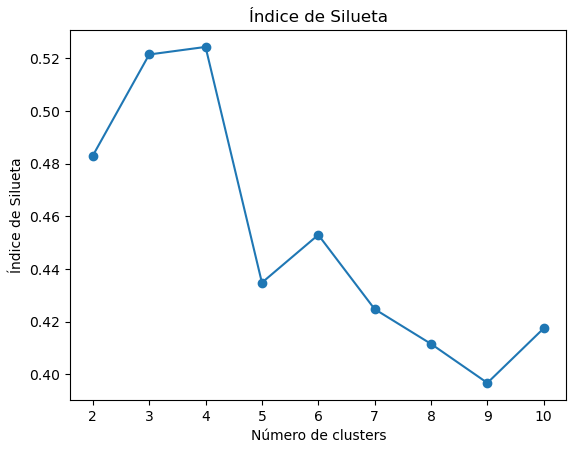

In [80]:
from sklearn.metrics import silhouette_score

# Evaluación con índice de silueta para diferentes números de clusters
silhouette_scores = []
for i in range(2, 11):  # Probar con 2 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Graficar el índice de silueta vs. número de clusters
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Índice de Silueta')
plt.xlabel('Número de clusters')
plt.ylabel('Índice de Silueta')
plt.show()

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


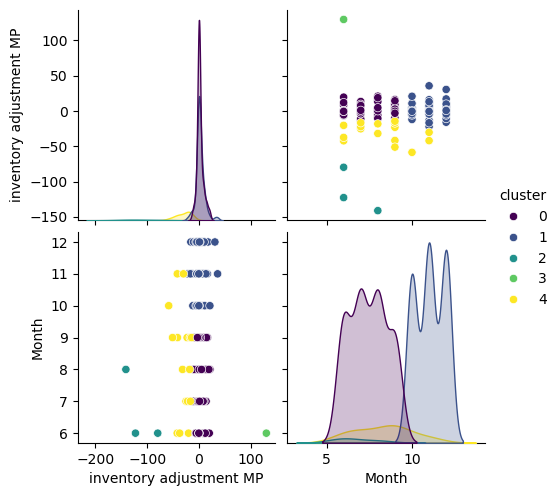

In [94]:
# Ajuste de hiperparámetros
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)
# Graficar una matriz de relaciones
sns.pairplot(df, hue='cluster', vars=['inventory adjustment MP', 'Month'], palette='viridis')
plt.show()

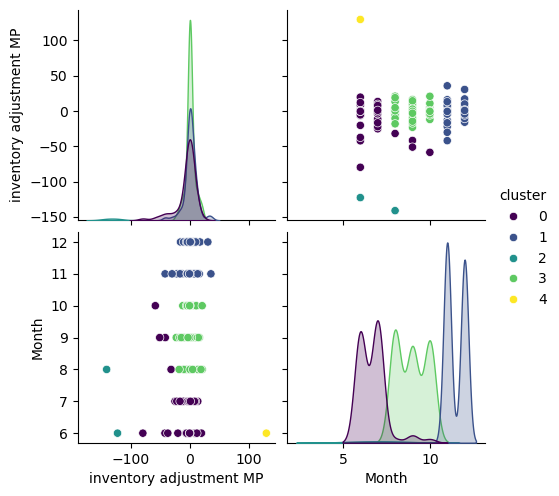

In [119]:
from sklearn.cluster import AgglomerativeClustering

# Aplicar Clustering Jerárquico
agg_clust = AgglomerativeClustering(n_clusters=5)
df['cluster'] = agg_clust.fit_predict(X_scaled)

# Graficar los resultados
sns.pairplot(df, hue='cluster', vars=['inventory adjustment MP', 'Month'], palette='viridis')
plt.show()

In [121]:
inventory_diff['Cluster'] = df['cluster']
inventory_diff.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_5024\2210842384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventory_diff['Cluster'] = df['cluster']


,FY,Month,ingredients,inventory adjustment MP,Cluster
0,2023,12,2,1.12,1
1,2023,12,3,11.40,1
2,2023,12,4,-2.89,1
3,2023,12,5,-15.89,1
4,2023,12,6,9.84,1


In [124]:
# Agrupar por cluster y mostrar estadísticas descriptivas
statistics_by_cluster = inventory_diff.groupby('Cluster').agg({
    'inventory adjustment MP': ['mean', 'std', 'min', 'max', 'median']
})

# Mostrar las estadísticas
print(statistics_by_cluster)

        inventory adjustment MP                                   
                           mean        std     min     max  median
Cluster                                                           
0                     -5.820149  17.205252  -79.72   19.67   -0.49
1                      0.796119  11.000619  -41.99   35.76    0.28
2                   -131.940000  13.067333 -141.18 -122.70 -131.94
3                      0.606353   7.701721  -23.09   21.02    0.22
4                    129.800000        NaN  129.80  129.80  129.80


Análisis de los clusters:

Cluster 0:

- Media: -5.82 → En promedio, los ajustes de inventario son negativos.
- Desviación estándar: 17.20 → Alta variabilidad en los valores dentro del cluster.
- Mínimo: -79.72
- Máximo: 19.67
- Mediana: -0.49 → La mayoría de los valores están cerca de 0, pero hay valores extremos negativos.
- Conclusión: Este cluster agrupa datos con ajustes de inventario mayormente negativos, con una alta dispersión de valores. Podría representar productos con fluctuaciones altas en inventario.

Cluster 1:

- Media: 0.80 → Ajustes de inventario cercanos a 0, lo que sugiere estabilidad.
- Desviación estándar: 11.00 → Hay cierta variabilidad, pero menor que en el cluster 0.
- Mínimo: -41.99
- Máximo: 35.76
- Mediana: 0.28 → Valores centrados alrededor de 0, con menor dispersión.
- Conclusión: Este cluster podría representar productos con ajustes de inventario estables, con valores ligeramente positivos y pocos extremos negativos.

Cluster 2:

- Media: -131.94 → Valores extremadamente negativos en los ajustes.
- Desviación estándar: 13.07 → Aunque los valores están concentrados en un rango negativo, hay variabilidad.
- Mínimo: -141.18
- Máximo: -122.70
- Mediana: -131.94 → La - mediana coincide con la media, lo que indica que los valores están bastante agrupados.
- Conclusión: Este cluster representa ajustes de inventario fuertemente negativos, lo que puede indicar productos con problemas graves de pérdida o ajustes sistemáticos hacia reducciones en el inventario.

Cluster 3:

- Media: 0.61 → Ajustes levemente positivos, similar al cluster 1.
- Desviación estándar: 7.70 → Menos variabilidad en comparación con el cluster 1.
- Mínimo: -23.09
- Máximo: 21.02
- Mediana: 0.22 → Valores centrados en 0, con menos fluctuaciones.
- Conclusión: Representa productos con ajustes de inventario estables, con pequeñas variaciones pero sin tendencias extremas.

Cluster 4:

- Media, - Mediana, - Mínimo y - Máximo: 129.80 → Todos los valores son iguales, lo que indica que este cluster tiene un solo valor.
- Desviación estándar: NaN → No hay variabilidad porque todos los valores son 129.80.
- Conclusión: Este cluster representa un ajuste de inventario muy específico, probablemente un producto con una única entrada en los datos.


Conclusiones generales:

Clusters 1 y 3 representan productos con ajustes de inventario estables, con valores cercanos a 0.

Podrían tratarse de productos que tienen ajustes ocasionales, pero sin tendencias extremas.

Cluster 0 muestra ajustes negativos significativos con alta variabilidad.

Este grupo puede representar productos con fluctuaciones frecuentes en el inventario, lo que podría indicar inconsistencias en la gestión del stock.

Cluster 2 es el más crítico, con valores extremadamente negativos.

Esto puede representar pérdidas significativas de inventario o errores en los registros que llevan a ajustes negativos sistemáticos.

Cluster 4 es un caso aislado con un valor fijo de 129.80.

Este cluster puede representar una situación única, como un producto con un ajuste de inventario fijo.
Recomendaciones:

Investigar el cluster 2:

Si estos productos representan pérdidas significativas, es crucial identificar si hay errores en la contabilidad del inventario o si se trata de productos defectuosos.
Monitorear el cluster 0:

La alta variabilidad puede ser una señal de que ciertos productos tienen problemas de gestión de inventario. Se recomienda analizar las causas de los ajustes negativos recurrentes.
Cluster 1 y 3 pueden ser considerados como productos con inventario estable.

No requieren acción inmediata, pero podrían analizarse si los ajustes pueden minimizarse aún más.
Cluster 4 parece ser un caso aislado.

Si este es un valor atípico, se podría considerar removerlo o analizar su origen.
